<a href="https://colab.research.google.com/github/Cchancee/air_pollution/blob/main/air_quality_forecasting_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Read CSVs with pandas
train = pd.read_csv('/content/drive/MyDrive/air_quality_data/train.csv')
test  = pd.read_csv('/content/drive/MyDrive/air_quality_data/test.csv')
sample_sub = pd.read_csv('/content/drive/MyDrive/air_quality_data/sample_submission.csv')

Mounted at /content/drive


In [3]:
# Convert datetime column
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime']  = pd.to_datetime(test['datetime'])

# Set datetime as index
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

# Remove 'No' column
train.drop('No', axis=1, inplace=True)
test.drop('No', axis=1, inplace=True)

print("Before imputation - missing values:")
print(train.isnull().sum())

imputer = KNNImputer(n_neighbors=5)
train_imputed = imputer.fit_transform(train)
train = pd.DataFrame(train_imputed, columns=train.columns, index=train.index)

print("\nAfter imputation - any NaNs left?", train.isnull().values.any())

Before imputation - missing values:
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64

After imputation - any NaNs left? False


In [4]:
# Feature Engineering
def add_temporal_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Drop original temporal columns
    df.drop(columns=['hour', 'dayofweek', 'month', 'day'], inplace=True)

    return df

In [5]:
# Apply feature engineering
train = add_temporal_features(train)
test = add_temporal_features(test)

# Prepare features and target
X_train = train.drop(columns=['pm2.5'])
y_train = train['pm2.5'].values

X_test = test  # test doesn't have pm2.5 column

print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Also scale the target variable
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()

Training features shape: (30676, 16)
Test features shape: (13148, 16)


In [6]:
# Create sequences for LSTM
def create_sequences(X, y, time_steps=72):
    """Create sequences for LSTM training"""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 72  # 3 days of hourly data
X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)

print("Sequence X shape:", X_seq.shape)
print("Sequence y shape:", y_seq.shape)

Sequence X shape: (30604, 72, 16)
Sequence y shape: (30604,)


In [7]:
# Proper time-based train/validation split
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_val_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_val_seq = y_seq[:split_index], y_seq[split_index:]

print("Train sequences:", X_train_seq.shape, y_train_seq.shape)
print("Validation sequences:", X_val_seq.shape, y_val_seq.shape)

Train sequences: (24483, 72, 16) (24483,)
Validation sequences: (6121, 72, 16) (6121,)


In [8]:
# Build Enhanced LSTM Model
def create_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    return model

In [9]:
# Create model
model = create_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

model.summary()

# Callbacks and Training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/air_quality_data/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=0.00001,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 72, 256)        │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 72, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,297 (966.00 KB)

 Trainable params: 247,297 (966.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/200
766/766 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.5350 - mae: 0.5194
Epoch 1: val_loss improved from inf to 0.67816, saving model to /content/drive/MyDrive/air_quality_data/best_model.keras
766/766 ━━━━━━━━━━━━━━━━━━━━ 209s 264ms/step - loss: 0.5349 - mae: 0.5193 - val_loss: 0.6782 - val_mae: 0.5449 - learning_rate: 0.0010
Epoch 2/200
766/766 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.3632 - mae: 0.4199
Epoch 2: val_loss did not improve from 0.67816
766/766 ━━━━━━━━━━━━━━━━━━━━ 191s 250ms/step - loss: 0.3632 - mae: 0.4199 - val_loss: 0.7654 - val_mae: 0.5695 - learning_rate: 0.0010
Epoch 3/200
766/766 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.3660 - mae: 0.4153
Epoch 3: val_loss did not improve from 0.67816
766/766 ━━━━━━━━━━━━━━━━━━━━ 203s 251ms/step - loss: 0.3660 - mae: 0.4153 - val_loss: 0.6975 - val_mae: 0.5728 - learning_rate: 0.0010
Epoch 4/200
766/766 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.2721 - mae: 0.3609
Epoch 4: val_loss did not improve from 0.678

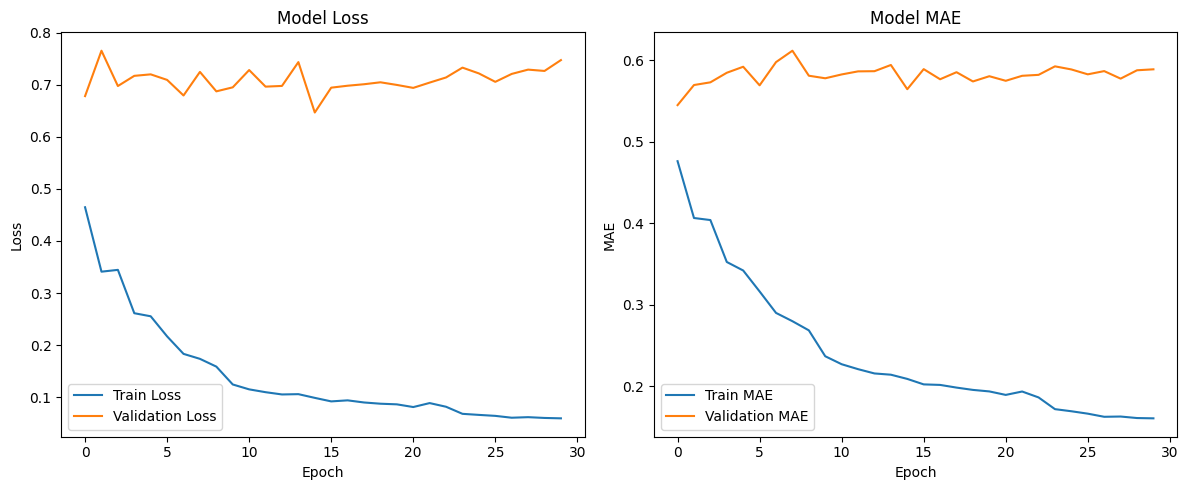

In [11]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Prepare test sequences
def create_test_sequences(X_train, X_test, time_steps):
    # Combine last time_steps of training with test data
    combined = np.vstack([X_train[-time_steps:], X_test])

    Xs = []
    for i in range(time_steps, len(combined)):
        Xs.append(combined[i-time_steps:i])

    return np.array(Xs)

X_test_seq = create_test_sequences(X_train_scaled, X_test_scaled, time_steps)
print("Test sequences shape:", X_test_seq.shape)

Test sequences shape: (13148, 72, 16)


In [13]:
# Make predictions
model = tf.keras.models.load_model('/content/drive/MyDrive/air_quality_data/best_model.keras')

# Predict on test sequences
test_predictions_scaled = model.predict(X_test_seq)
test_predictions = y_scaler.inverse_transform(test_predictions_scaled).flatten()

# Clip predictions to reasonable range based on training data
pm25_min, pm25_max = y_train.min(), y_train.max()
test_predictions = np.clip(test_predictions, pm25_min * 0.9, pm25_max * 1.1)
print(f"Predictions range: {test_predictions.min():.2f} to {test_predictions.max():.2f}")


411/411 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step
Predictions range: 39.93 to 487.62


In [ ]:
# Create submission file
if len(test_predictions) > len(test):
    test_predictions = test_predictions[:len(test)]
elif len(test_predictions) < len(test):
    test_predictions = np.pad(test_predictions, (0, len(test) - len(test_predictions)),
                             mode='edge')


submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': test_predictions
})

submission = submission.sort_values('row ID')

# Save submission
submission_path = '/content/drive/MyDrive/air_quality_data/submission_optimized.csv'
submission.to_csv(submission_path, index=False)

print(f"Submission saved to {submission_path}")
print("Submission head:")
print(submission.head())

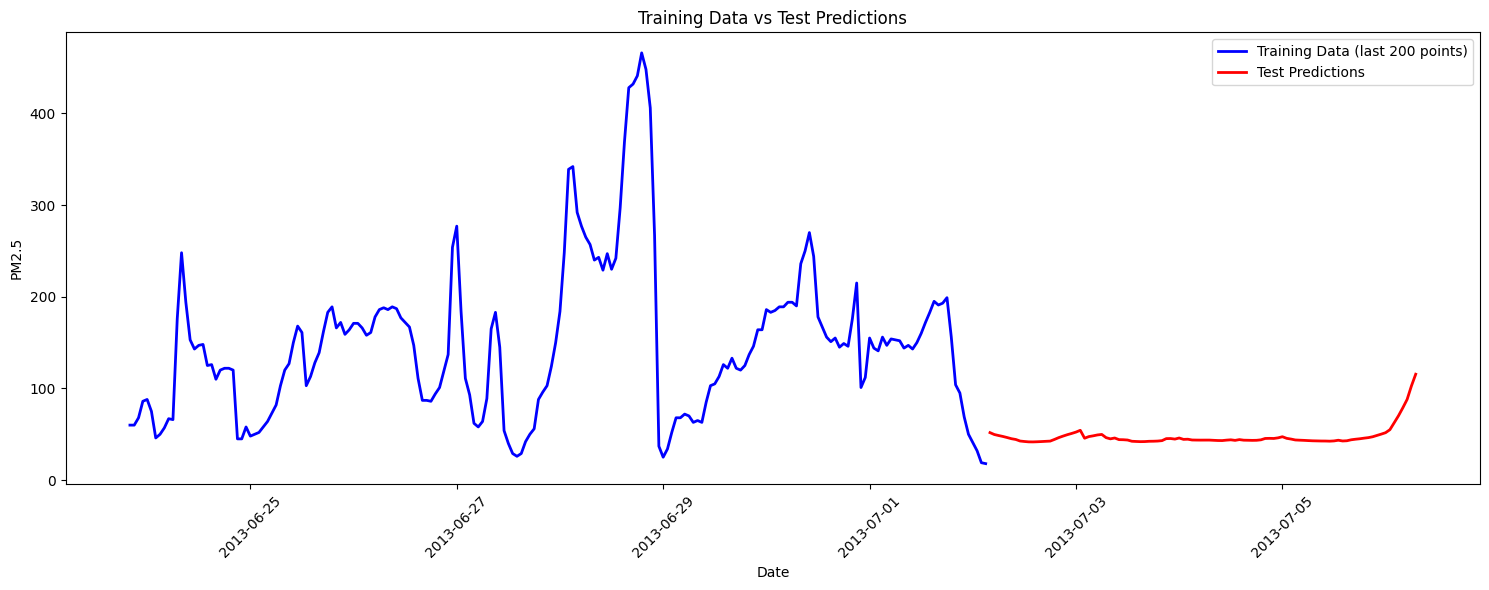

In [15]:
# Visualize predictions
plt.figure(figsize=(15, 6))

# Plot last part of training data and predictions
last_train_points = 200
plot_train = y_train[-last_train_points:]
plot_dates = train.index[-last_train_points:]

plt.plot(plot_dates, plot_train, label='Training Data (last 200 points)', color='blue', linewidth=2)

# Plot predictions
pred_dates = test.index[:min(100, len(test_predictions))]
pred_values = test_predictions[:len(pred_dates)]

plt.plot(pred_dates, pred_values, label='Test Predictions', color='red', linewidth=2)

plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('Training Data vs Test Predictions')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
